<a href="https://colab.research.google.com/github/iiMoham/sheepClassification/blob/main/sheepClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision timm scikit-learn pandas numpy albumentations>=1.1.0

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler, autocast


In [ ]:
import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 24
IMG_SIZE = 416


In [ ]:
train_aug = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=IMG_SIZE//20, max_width=IMG_SIZE//20, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

def tta_transforms(image):
    transforms = [
        A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ]),
        A.Compose([
            A.HorizontalFlip(p=1.0),
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ]),
    ]
    return [tr(image=image)['image'] for tr in transforms]


In [ ]:
class SheepDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.label_map = {lbl: idx for idx, lbl in enumerate(sorted(df['label'].unique()))}
        self.inv_map = {v: k for k, v in self.label_map.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, row['filename'])).convert('RGB'))
        if self.transforms:
            img = self.transforms(image=img)['image']
        label = self.label_map[row['label']]
        return img, label


In [ ]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [ ]:
def get_model(num_classes):
    # Use built-in num_classes to ensure correct head and pooling
    model = timm.create_model(
       "hf_hub:timm/efficientnet_b5.sw_in12k",
        pretrained=True,
        num_classes=num_classes,
        global_pool='avg'
    )
    return model.to(DEVICE)

criterion = nn.CrossEntropyLoss()


In [ ]:
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        images, y_a, y_b, lam = mixup_data(images, labels)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)


In [ ]:
def validate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().tolist())
            trues.extend(labels.tolist())
    return f1_score(trues, preds, average='weighted')


In [ ]:
# Cross-Validation Loop and OOF
train_df = pd.read_csv('/content/drive/MyDrive/data/train_labels.csv')
oof_preds = np.zeros(len(train_df), dtype=int)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    print(f"\n=== Fold {fold+1}/{FOLDS} ===")
    df_train, df_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    train_set = SheepDataset(df_train, '/content/drive/MyDrive/data/train/', transforms=train_aug)
    val_set = SheepDataset(
        df_val,
        '/content/drive/MyDrive/data/train/',
        transforms=A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])
    )
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = get_model(len(train_set.label_map))
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=3e-3, epochs=EPOCHS, steps_per_epoch=len(train_loader)
    )
    scaler = GradScaler()

    best_f1 = 0
    for epoch in range(1, EPOCHS+1):
        loss = train_one_epoch(model, train_loader, optimizer, scaler)
        scheduler.step()
        val_f1 = validate(model, val_loader)
        print(f"Epoch {epoch}: Loss={loss:.4f}, Val F1={val_f1:.4f}")
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"model_fold{fold}.pth")
    print(f"Fold {fold+1} Best F1: {best_f1:.4f}")

    # OOF predictions with TTA
    model.load_state_dict(torch.load(f"model_fold{fold}.pth"))
    model.eval()
    with torch.no_grad():
        for idx, row in enumerate(df_val.itertuples()):
            img = np.array(Image.open(os.path.join('/content/drive/MyDrive/data/train/', row.filename)).convert('RGB'))
            tts = tta_transforms(img)
            outs = [model(t.unsqueeze(0).to(DEVICE)).softmax(1).cpu().numpy() for t in tts]
            oof_preds[val_idx[idx]] = np.argmax(np.mean(outs, axis=0))




=== Fold 1/5 ===


config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/211M [00:00<?, ?B/s]

Epoch 1: Loss=3.7846, Val F1=0.7174
Epoch 2: Loss=1.7755, Val F1=0.7454
Epoch 3: Loss=1.2527, Val F1=0.8382
Epoch 4: Loss=0.7564, Val F1=0.9278
Epoch 5: Loss=0.9307, Val F1=0.9036
Epoch 6: Loss=0.8015, Val F1=0.9258
Epoch 7: Loss=0.5531, Val F1=0.9032
Epoch 8: Loss=0.5054, Val F1=0.9220
Epoch 9: Loss=0.5352, Val F1=0.9336
Epoch 10: Loss=0.5734, Val F1=0.9267
Epoch 11: Loss=0.5538, Val F1=0.8852
Epoch 12: Loss=0.6147, Val F1=0.9181
Epoch 13: Loss=0.4682, Val F1=0.9246
Epoch 14: Loss=0.5266, Val F1=0.9388
Epoch 15: Loss=0.5976, Val F1=0.9342
Fold 1 Best F1: 0.9388

=== Fold 2/5 ===
Epoch 1: Loss=3.9657, Val F1=0.6676
Epoch 2: Loss=1.5440, Val F1=0.8156
Epoch 3: Loss=1.0089, Val F1=0.8404
Epoch 4: Loss=0.8147, Val F1=0.9000
Epoch 5: Loss=0.8195, Val F1=0.9357
Epoch 6: Loss=0.6944, Val F1=0.9206
Epoch 7: Loss=0.4186, Val F1=0.9709
Epoch 8: Loss=0.5792, Val F1=0.9560
Epoch 9: Loss=0.5035, Val F1=0.9340
Epoch 10: Loss=0.6863, Val F1=0.9335
Epoch 11: Loss=0.5629, Val F1=0.9406
Epoch 12: Loss=

In [ ]:
label_map = {lbl: idx for idx, lbl in enumerate(sorted(train_df['label'].unique()))}
print("OOF F1:", f1_score(train_df['label'].map(lambda x: label_map[x]), oof_preds, average='weighted'))

OOF F1: 0.9432723694112072


In [ ]:
# Inference & Ensemble on Test Set
test_files = pd.DataFrame(os.listdir('/content/drive/MyDrive/data/test/'), columns=['filename'])
all_preds = np.zeros((len(test_files), len(train_set.label_map)))

for fold in range(FOLDS):
    model = get_model(len(train_set.label_map))
    model.load_state_dict(torch.load(f"model_fold{fold}.pth"))
    model.eval()
    with torch.no_grad():
        for idx, fname in enumerate(test_files['filename']):
            img = np.array(Image.open(os.path.join('/content/drive/MyDrive/data/test/', fname)).convert('RGB'))
            tts = tta_transforms(img)
            outs = [model(t.unsqueeze(0).to(DEVICE)).softmax(1).cpu().numpy() for t in tts]
            all_preds[idx] += np.mean(outs, axis=0).flatten()

all_preds /= FOLDS
labels = [train_set.inv_map[np.argmax(p)] for p in all_preds]
submission = pd.DataFrame({'filename': test_files['filename'], 'label': labels})
submission.to_csv('submission.csv', index=False)
print("Ensembled submission saved to submission_ensemble.csv")


Ensembled submission saved to submission_ensemble.csv


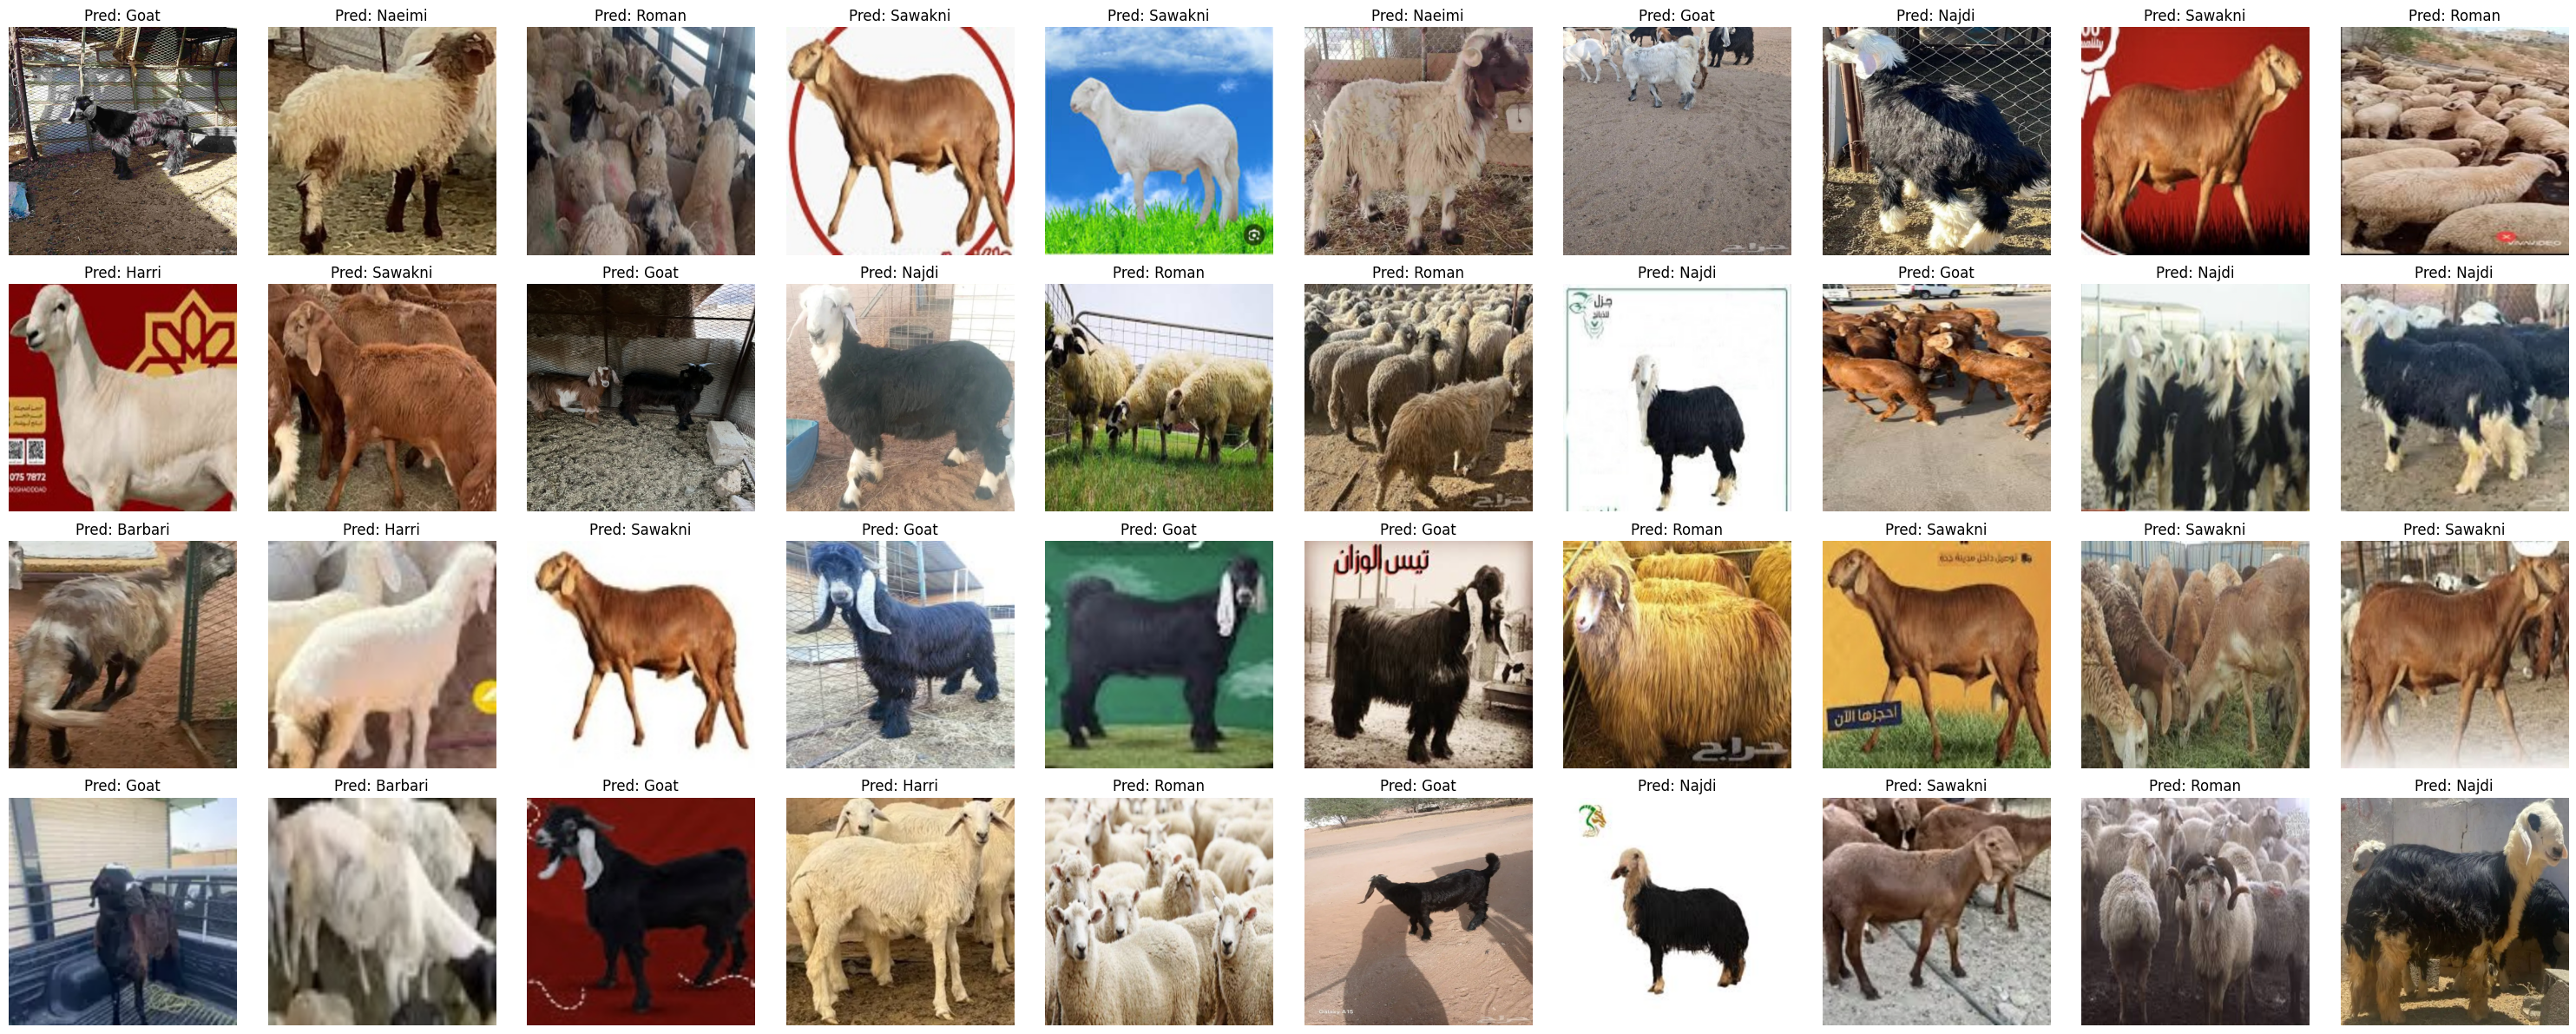

In [ ]:
import matplotlib.pyplot as plt

class SimpleTestDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = np.array(Image.open(img_path).convert('RGB'))
        if self.transforms:
            img = self.transforms(image=img)['image']
        return img, row['filename']

test_results_df = pd.DataFrame({'filename': test_files['filename'], 'predicted_label': labels})


display_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
])


test_dataset_display = SimpleTestDataset(test_results_df, '/content/drive/MyDrive/data/test/', transforms=display_transforms)

# --- Display Predicted Images ---

def display_predicted_images(dataset, results_df, num_rows=3, num_cols=10):
    """
    Displays a few test images along with their predicted labels in a grid.
    """
    num_images = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()

    display_indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    for i, idx in enumerate(display_indices):
        if i >= num_images:
            break

        img_tensor, filename = dataset[idx]

        predicted_label = results_df[test_results_df['filename'] == filename]['predicted_label'].iloc[0]

        if isinstance(img_tensor, torch.Tensor):
            img_display = img_tensor.permute(1, 2, 0).numpy()

            original_img = np.array(Image.open(os.path.join(dataset.img_dir, filename)).convert('RGB'))
            img_display = display_transforms(image=original_img)['image']

        else:
            img_display = img_tensor

        axes[i].imshow(img_display)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    # Hide any unused subplots if num_images is less than num_rows * num_cols
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_predicted_images(test_dataset_display, test_results_df, num_rows=4, num_cols=10)

In [1]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [2]:
!git add .


error: open("drive/MyDrive/Assessment.gform"): Operation not supported
error: unable to index file 'drive/MyDrive/Assessment.gform'
fatal: adding files failed


In [ ]:
!git commit -m ""